# Cookie cutter

The aim of this notebook is to produce summary statistics for Hazards over NCRA regions, with the flexibility to apply the method to any shapefile region.

Typical statistics include median, mean, min, max, 10th, 90th percentiles

This method has used guidance from [https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb]

<div>
<img src="cookie_cutter.jpg" width="500" title="Cookie cutter"/>
</div>

## Step 1 - access needed packages

In [1]:
# navigate to correct working directory

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats, get_regions

regions = get_regions(["ncra_regions", "australia"])

In [4]:
import xarray as xr
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [5]:
# read in the shapefile with regions you will use
# from acs_plotting_maps import regions_dict
# ncra_gdf = gpd.read_file(f'/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/ncra_regions/ncra_regions.shp')
# ncra_gdf["abbrevs"]=['VIC', 'NT','TAS', 'SA', 'NSW', 'WAN', 'WAS', 'SQ', 'NQ']
# regions = regionmask.from_geopandas(ncra_gdf, names="NAME", abbrevs="abbrevs")
regions

<regionmask.Regions 'ncra_regions-australia'>
overlap:  True

Regions:
0  WANorth                          Western Australia North
1  WASouth                          Western Australia South
2      NSW New South Wales and Australian Capital Territory
3      VIC                                         Victoria
4       SA                                  South Australia
5      TAS                                         Tasmania
6       NT                               Northern Territory
7 QLDNorth                                 Queensland North
8 QLDSouth                                 Queensland South
9      AUS                                        Australia

[10 regions]

## Step 2 - Load and prepare data

Open the data you need. 


In [6]:
%%time 
# open Hazard data
# this is a slowish part of the code. It is likely to be reused if you're interested in calculating multiple statistics
filename = "/g/data/ia39/ncra/bushfire/fire_climate_classes_AGCD-05i_MM_ssp370_v1-r1-ACS-NRNBC_GWL12.nc"
ds = xr.open_dataset(filename, use_cftime = True,)
# ds=ds.rename({"latitude":"lat", "longitude": "lon"})
# ds = ds.assign_coords(lat = ds.lat.astype("double").round(3), lon = ds.lon.astype("double").round(3))

CPU times: user 3.58 s, sys: 1.35 s, total: 4.93 s
Wall time: 7.11 s


In [7]:
ds

<xarray.Dataset> Size: 5MB
Dimensions:                      (lat: 691, lon: 886, class: 5)
Coordinates:
  * lat                          (lat) float64 6kB -44.5 -44.45 ... -10.05 -10.0
  * lon                          (lon) float64 7kB 112.0 112.0 ... 156.2 156.2
    clim_period                  <U6 24B ...
  * class                        (class) int64 40B 0 1 2 3 4
Data variables:
    fire_climate_class           (lat, lon) float64 5MB ...
    class_code                   (class) int64 40B ...
    class_long_description       (class) <U23 460B ...
    stern_dehoedt_minor_classes  (class) <U50 1kB ...
    colour_map                   (class) <U7 140B ...
Attributes: (12/13)
    data_source:                  BARPA ia39
    notebook:                     stern_dehoedt_ernst_2000_BARPA.ipynb
    Global_Warming_Level:         GWL1.2
    reference:                    Stern, H., De Hoedt, G., & Ernst, J. (2000)...
    GCM_model:                    EC-Earth3, CESM2, ACCESS-CM2, CMCC-ESM2, CN...
    Experiment_ID:                ssp370, ssp370, ssp370, ssp370, ssp370, ssp...
    ...                           ...
    RCM_model:                    CCAM-v2203-SN, CCAM-v2203-SN, CCAM-v2203-SN...
    RCM_model_version_ID:         v1-r1-ACS-MRNBC-AGCD-1960-2022, v1-r1-ACS-M...
    start_year:                   2004, 2010, 2010, 2012, 2016, 2015, 2011, 2...
    end_year:                     2023, 2029, 2029, 2031, 2035, 2034, 2030, 2...
    GWL:                          GWL1.2
    bias_correction_description:  MRNBC-AGCD

## Step 3 - Create your mask

There's a range of ways to calculate your mask:
- **regions.mask_3D(ds)** will create a "mask" array that is ```True``` for all grid cells whose centre point falls within a particular state/territory and ```False``` elsewhere
- **regions.mask_3D_frac_approx(ds)** will calculate the fraction of each grid cell that overlaps with each shape
- **mask_10pct** you may create a mask from the fraction values we need to decide on a minimum overlap threshold. eg ```mask_10pct = frac >= 0.1```

Fractional masking```regions.mask_3D_frac_approx(ds)``` which will weigh each lat lon grid by the approximate fraction of the area that lay within the shapefile geometery. It  is probably the most accurate, but more expensive than the simple mask_3D.

The masking methods return an xr.DataArray with three dimensions:  **region**, **lat**, and **lon**.

In [8]:
# create your mask
# you only need one mask. here are two examples. 
# you can also is a keyword fro the function to calculate the mask, but if you're performing multiple calculations, this can be slow.

In [9]:
%%time
# calculate weighted mask this is a very slow part of the code and
# can be reused for any datasets using the same regions and the same lat lon
mask_frac = regions.mask_3D_frac_approx(ds)

CPU times: user 20.8 s, sys: 1.95 s, total: 22.8 s
Wall time: 22.8 s


In [10]:
%%time
mask_centred = regions.mask_3D(ds)

CPU times: user 4.51 s, sys: 188 ms, total: 4.7 s
Wall time: 4.71 s


## Step 4: Use function
To apply mask calculate a statistic to summarise each region 

In [11]:
# calculate the stats using the acs_region_fractional_stats function
# the function can infer/calculate many of the inputs, but it will be faster to explicitly specify them in the function, eg var, dims, mask  

# start, end = ("1991", "2010") 
dims = ( "lat", "lon")
# var = "pr"
var = "fire_climate_class"
how = ["mean", "min", "max", "mode"]
outfile="out.csv"
mask = mask_centred

In [12]:
%%time
da_summary = acs_regional_stats(ds=ds, infile=filename, var=var, mask = mask, dims=dims, how = how, outfile=outfile)
da_summary

CPU times: user 3.97 s, sys: 1.84 s, total: 5.82 s
Wall time: 6.42 s


<xarray.Dataset> Size: 3kB
Dimensions:                  (region: 10)
Coordinates:
    clim_period              <U6 24B 'GWL1.2'
  * region                   (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs                  (region) <U8 320B 'WANorth' 'WASouth' ... 'AUS'
    names                    (region) <U48 2kB 'Western Australia North' ... ...
Data variables:
    fire_climate_class_mean  (region) float64 80B 101.0 101.4 ... 101.2 101.3
    fire_climate_class_min   (region) float64 80B 100.0 101.0 ... 100.0 100.0
    fire_climate_class_max   (region) float64 80B 102.0 104.0 ... 104.0 104.0
    fire_climate_class_mode  (region) float64 80B 101.0 101.0 ... 101.0 101.0

In [13]:
# %%time
# da_summary = acs_regional_stats(ds=ds, mask = "fractional", how = ["mean", "min", "max"], outfile="out.csv")
# da_summary

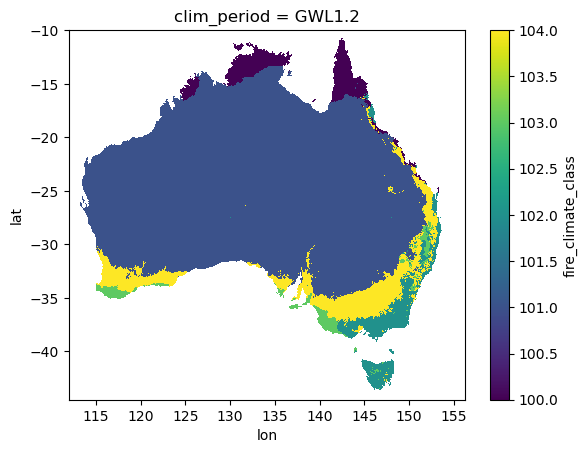

In [14]:
ds[var].plot()

In [15]:
ds_masked = ds[var].where(mask_centred)
ds_masked

<xarray.DataArray 'fire_climate_class' (lat: 691, lon: 886, region: 10)> Size: 49MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat          (lat) float64 6kB -44.5 -44.45 -44.4 ... -10.1 -10.05 -10.0
  * lon          (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
    clim_period  <U6 24B 'GWL1.2'
  * region       (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs      (region) <U8 320B 'WANorth' 'WASouth' ... 'QLDSouth' 'AUS'
    names        (region) <U48 2kB 'Western Australia North' ... 'Australia'

In [16]:
props[i].to_dict()

NameError: name 'props' is not defined

In [ ]:
mask

In [ ]:
ds_masked

In [ ]:
var = "AI"
ds_ai = xr.open_dataset("/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_2D_GWL20_percentiles10-50-90.nc")

ds=ds_ai.sel(quantile = 0.5)

mask = regions.mask_3D(ds)
ds_masked = ds.where(mask)[var]

stat = "proportions"
bins = [0.0, 0.05, 0.2, 0.5, 0.65]
bin_labels =  ["Hyper-arid", "Arid", "Semi-arid", "Dry sub-humid"]

df_masked = ds_masked.to_dataframe()
df_masked["category"] = pd.cut(df_masked[var], bins, labels=bin_labels, ordered=True)
proportion_dict = {}
props = df_masked.groupby("region").value_counts(["category"], normalize=True).round(4)
for i in range(len(ds_masked.region)):
    proportion_dict[i] = props[i].to_dict() 
    # limit to first 20 categories
    proportion_dict[i]  = dict(list(proportion_dict[i].items())[0: 20]) 
    
d = {"coords": {
        "region": {"dims": "region", "data": list(proportion_dict.keys()),}
    },
     "dims": "region",
    "data":list(proportion_dict.values()),
    "name": stat}
df = xr.DataArray.from_dict(d).rename(f"{var}_cat_{stat}")

df

In [ ]:
dict(list(test_dict.items())[0: 20]) 

In [ ]:

proportion_dict

In [ ]:
ds_masked.to_dataframe().groupby(["region"])[var].agg(pd.Series.mode).to_xarray()

In [ ]:
ds_weighted = ds[var].weighted(mask )

In [ ]:
ds_weighted.sum(dim=("lat", "lon"))

In [ ]:
# mode calculation for each region
xr.merge([ds_masked.to_dataframe().groupby(['region'])[var].agg(pd.Series.mode).to_xarray().rename("mode"), ds_weighted.sum(dim=("lat", "lon")).rename("sum")],)


In [ ]:
# count_df = pd.DataFrame(df_masked.value_counts(normalize=True)).droplevel("names")
# count_df.sort_index(level="abbrevs", sort_remaining=False)

In [ ]:
ds_masked = ds.where(mask_centred)

In [ ]:
# ds.AI.plot()

In [ ]:
df = ds.where(mask_centred).to_dataframe()
df["category"] = pd.cut(df[var], bins, labels=bin_labels, ordered=True)
df.groupby("region")["category"].agg(pd.Series.mode).to_xarray().rename("mode") 

In [ ]:
filename = "/g/data/ia39/ncra/drought_aridity/ai/AI-atmospheric-based_NHP1-AUS-5_ACCESS1-0_rcp45_r1i1p1__r240x120-ISIMIP2b_2D_GWL12.nc"
ds = xr.open_dataset(filename, use_cftime = True,)
var="AI"
dims=("lat", "long",)
bins=  [0., 0.05, 0.2, 0.5, 0.65]
bin_labels =["Hyper-arid", "Arid", "Semi-arid", "Dry sub-humid"]
mask_centred = regions.mask_3D(ds)


In [ ]:
df = acs_regional_stats(ds=ds, var=var,  mask = mask_centred, how = ["min", "max", "mode"], dims = ("lat", "lon"), bins = bins, bin_labels=bin_labels)
df

In [ ]:
if bins is not None:
    df = ds_masked.to_dataframe()
    df["category"] = pd.cut(df[var], bins, labels=bin_labels, ordered=True)

In [ ]:
df

In [ ]:
ds_weighted = ds[var].weighted(mask)
dims=("lat", "lon")
ds_weighted.sum(dim=dims)

In [ ]:
lat_weights = np.cos(np.deg2rad(ds['lat']))
ds_weighted = ds[var].weighted(mask * lat_weights)

In [ ]:
ds

In [ ]:
var = "fire_climate_class"
# ds_masked.to_dataframe().groupby(['region'])[var].agg(pd.Series.mode)

In [ ]:
df = acs_regional_stats(ds=ds, var=var,  mask = mask_frac, how = ["min", "mode"], dims = ("lat", "lon"))
df

In [ ]:
acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = dims, how = ["mean", "min", "max"], outfile = "out.csv")

In [ ]:
## extra things

In [ ]:
da_p90 = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "quantile", quantile=0.9)

In [ ]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean

In [ ]:
%%time
# regional mean
da_max = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "max")
da_max

In [ ]:
xr.merge([da_mean, da_max, da_p90])

In [ ]:
xr.merge([da_mean, da_max, da_p90]).to_dataframe()

In [ ]:
xr.merge([da_mean, da_max, da_p90])[["names", "pr_p90"]]

In [ ]:
%%time
# select one region
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("time", "lat", "lon"), how = "mean", select_abbr=["VIC"])
da_mean

In [ ]:
%%time
# select one region and get timeseries
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean", select_abbr=["VIC"])
da_mean.squeeze()


In [ ]:
da_mean.squeeze().plot()

In [ ]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "fractional", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean.to_dataframe()

In [ ]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "centred", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean")
da_mean.to_dataframe()

In [ ]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask = "min_overlap", start=start, end=end, dims = ("time", "lat", "lon"), how = "mean", overlap_threshold=0.3)
da_mean.to_dataframe()


In [ ]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean")
da_mean.to_dataframe(dim_order=["region", "time"])

In [ ]:
da_mean.sel(region=(regions.abbrevs.index("NSW"))).plot()

In [ ]:
%%time
# regional mean
da_mean = acs_regional_stats(ds=ds, var=var, mask =mask_frac, start=start, end=end, dims = ("lat", "lon"), how = "mean")
da_mean.to_dataframe(dim_order=["region", "time"])


In [ ]:
# calculate the mean rx1day value from the 20 years for the global warming level (GWL)
ds = ds.sel(time = slice(start, end))
da_mean = ds["pr"].mean(dim="time")
da_mean.plot()

In [ ]:
# import needed packages
from acs_area_statistics import acs_regional_stats, regions
import xarray as xr

In [ ]:
# calculate the stats using the acs_region_fractional_stats function
# Find the mean value for each region
filename = "/g/data/ia39/ncra/extratropical_storms/5km/lows_AGCD-05i_ACCESS-CM2_historical_r4i1p1f1_BOM_BARPA-R_v1-r1_annual.nc"
ds = xr.open_dataset(filename, use_cftime = True,)
var = "low_freq"
mask_frac = regions.mask_3D_frac_approx(ds)
start, end = ("1991", "2010")
dims = ("time", "lat", "lon",)

da_mean = acs_regional_stats(ds=ds,var=var, mask=mask_frac, start=start, end=end, dims = dims, how = "mean")
da_mean